## 正則化

### 過学習

過学習が起きる主な要因

- パラメータを大量に持ち、表現力が高いモデルである
- 訓練データが少ない

本来６００００個あるMNISTの訓練データを３００個にしてわざと過学習を発生させる。
ネットワークも複雑性を高めるために７層にする。

In [6]:
# coding: utf-8
import os
import sys

sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD


def test_regularization(wdl=0):
    (x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)
    
    # 過学習を再現するために、学習データを削減
    x_train = x_train[:300]
    t_train = t_train[:300]

    # weight decay（荷重減衰）の設定 =======================
    weight_decay_lambda = wdl # weight decayを使用しない場合
    #weight_decay_lambda = 0.1
    # ====================================================

    network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                            weight_decay_lambda=weight_decay_lambda)
    optimizer = SGD(lr=0.01)

    max_epochs = 201
    train_size = x_train.shape[0]
    batch_size = 100

    train_loss_list = []
    train_acc_list = []
    test_acc_list = []

    iter_per_epoch = max(train_size / batch_size, 1)
    epoch_cnt = 0

    for i in range(1000000000):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]

        grads = network.gradient(x_batch, t_batch)
        optimizer.update(network.params, grads)

        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, t_train)
            test_acc = network.accuracy(x_test, t_test)
            train_acc_list.append(train_acc)
            test_acc_list.append(test_acc)

            if epoch_cnt % 25 == 0:
                print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

            epoch_cnt += 1
            if epoch_cnt >= max_epochs:
                break


    # 3.グラフの描画==========
    markers = {'train': 'o', 'test': 's'}
    x = np.arange(max_epochs)
    plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
    plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.ylim(0, 1.0)
    plt.legend(loc='lower right')
    plt.show()

epoch:0, train acc:0.0966666666667, test acc:0.0914
epoch:25, train acc:0.683333333333, test acc:0.4816
epoch:50, train acc:0.9, test acc:0.6724
epoch:75, train acc:0.983333333333, test acc:0.7224
epoch:100, train acc:1.0, test acc:0.7493
epoch:125, train acc:1.0, test acc:0.7571
epoch:150, train acc:1.0, test acc:0.7617
epoch:175, train acc:1.0, test acc:0.7658
epoch:200, train acc:1.0, test acc:0.7683


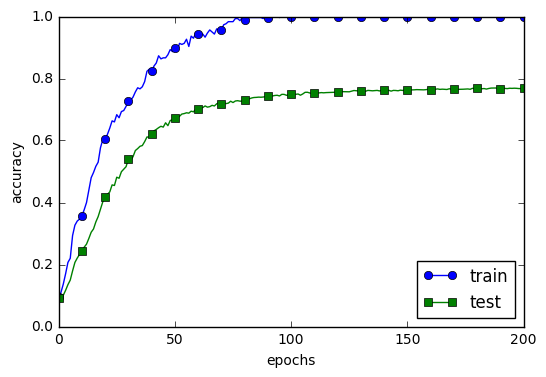

In [7]:
test_regularization(wdl=0)

### Weight decay

過学習抑制のために、大きな重みを持つことにペナルティを与えるWeight decayが用いられる。
過学習は大きな重みパラメータを持つことで発生することが多い。

重みの２乗ノルム（L2ノルム）を損失関数に加算する。$\frac{1}{2}\lambda W^2$とし、$\lambda$は正則化の強さをコントロールするハイパーパラメータ、$\frac{1}{2}$は微分の結果を$lambda W$にするため。

epoch:0, train acc:0.08, test acc:0.0896
epoch:25, train acc:0.636666666667, test acc:0.4364
epoch:50, train acc:0.826666666667, test acc:0.636
epoch:75, train acc:0.87, test acc:0.6986
epoch:100, train acc:0.896666666667, test acc:0.7102
epoch:125, train acc:0.913333333333, test acc:0.7295
epoch:150, train acc:0.92, test acc:0.7207
epoch:175, train acc:0.92, test acc:0.7211
epoch:200, train acc:0.92, test acc:0.7305


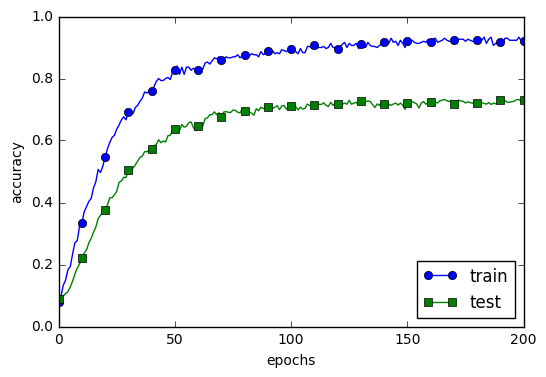

In [8]:
test_regularization(wdl=0.1)

### Dropout

ニューラルネットワークが複雑になるとWeight decayだけでは困難になる。
そこでDropoutという手法がよく用いられる。

Dropoutはニューロンをランダムに消去しながら学習する。
消去したニューロンはデータ伝送を行わなくなる。テスト時には消去した割合を乗算して出力する。

In [10]:
class Dropout:
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None
        
    def forward(self, x, train_flg=True):
        if train_flg:
            self.masl = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)
        
    def backward(self, dout):
        return dout * self.mask

train loss:2.30888449222
=== epoch:1, train acc:0.08, test acc:0.0759 ===
train loss:2.30008720026
train loss:2.30981115498
train loss:2.30360788149
=== epoch:2, train acc:0.0766666666667, test acc:0.0722 ===
train loss:2.29014518614
train loss:2.31709079325
train loss:2.28527337424
=== epoch:3, train acc:0.08, test acc:0.0745 ===
train loss:2.30904958864
train loss:2.29971337407
train loss:2.30388317351
=== epoch:4, train acc:0.09, test acc:0.0782 ===
train loss:2.28953436563
train loss:2.29368592483
train loss:2.30070526314
=== epoch:5, train acc:0.1, test acc:0.0811 ===
train loss:2.30290245462
train loss:2.30654506077
train loss:2.3017326819
=== epoch:6, train acc:0.116666666667, test acc:0.0847 ===
train loss:2.29611938729
train loss:2.30582107507
train loss:2.30275566427
=== epoch:7, train acc:0.126666666667, test acc:0.0868 ===
train loss:2.29773162672
train loss:2.30652915891
train loss:2.29994649606
=== epoch:8, train acc:0.123333333333, test acc:0.091 ===
train loss:2.2894834

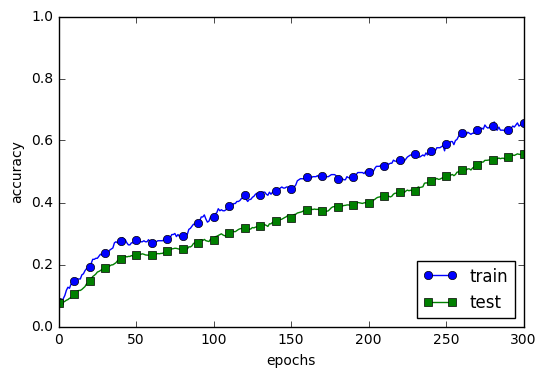

In [9]:
# coding: utf-8
import os
import sys
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 過学習を再現するために、学習データを削減
x_train = x_train[:300]
t_train = t_train[:300]

# Dropuoutの有無、割り合いの設定 ========================
use_dropout = True  # Dropoutなしのときの場合はFalseに
dropout_ratio = 0.2
# ====================================================

network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                              output_size=10, use_dropout=use_dropout, dropout_ration=dropout_ratio)
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=301, mini_batch_size=100,
                  optimizer='sgd', optimizer_param={'lr': 0.01}, verbose=True)
trainer.train()

train_acc_list, test_acc_list = trainer.train_acc_list, trainer.test_acc_list

# グラフの描画==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

## ハイパーパラメータの検証

各層のニューロンの数やバッチサイズ、パラメータの更新の際の学習係数やWeight decayなど多くのハイパーパラメータが存在する。
ハイパーパラメータの値を探索する方法について説明する。

### 検証データ

ハイパーパラメータの調整にテストデータを使うのは過学習を起こすためやらない。
ハイパーパラメータ専用の検証データを用意する。

データセットによっては訓練データ、検証データ、テストデータが用意されているものがある。
そうでないものに関しては、訓練データの20%を分離して検証データとするなどする。

### ハイパーパラメータの最適化

ハイパーパラメータの範囲をある程度ざっくり決め、絞り込んでいくのがよいとされる。

小さめのエポックで評価するのを繰り返し結果からハイパーパラメータを消える実践的な方法の他に、ベイズ最適化という手法もある。

/Users/adwd/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/ipykernel/__main__.py:21: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/adwd/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/ipykernel/__main__.py:22: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/adwd/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/ipykernel/__main__.py:23: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/adwd/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/ipykernel/__main__.py:24: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


val acc:0.11 | lr:5.060139176851365e-06, weight decay:6.559848253230767e-08
val acc:0.12 | lr:3.994405528802223e-06, weight decay:1.710256411248637e-08
val acc:0.1 | lr:0.00013796784125730537, weight decay:1.576833895476606e-05
val acc:0.25 | lr:0.0013960560273026735, weight decay:7.30577217804396e-07
val acc:0.19 | lr:0.0005175862868829616, weight decay:7.359442400129677e-08
val acc:0.11 | lr:0.00028156058087728175, weight decay:2.1075400316324584e-05
val acc:0.11 | lr:0.00022264688152563844, weight decay:1.1637153915747776e-08
val acc:0.04 | lr:4.239894093321466e-06, weight decay:4.8642259998431053e-08
val acc:0.1 | lr:2.971571343501165e-05, weight decay:3.499385318666139e-08
val acc:0.1 | lr:0.00010722476167454637, weight decay:7.754031054886618e-08
val acc:0.1 | lr:1.5644331987995493e-05, weight decay:1.1268436750902069e-07
val acc:0.13 | lr:7.296353268926051e-05, weight decay:1.868580081133235e-08
val acc:0.08 | lr:0.00041767081249910595, weight decay:3.743925720284186e-08
val acc

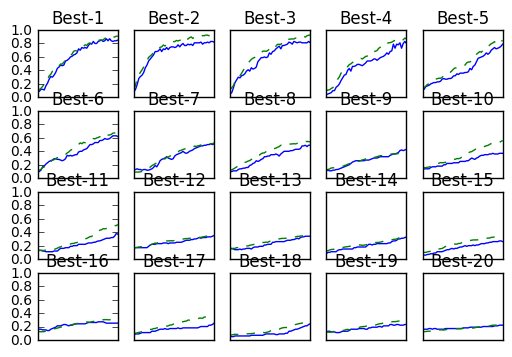

In [11]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.util import shuffle_dataset
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 高速化のため訓練データの削減
x_train = x_train[:500]
t_train = t_train[:500]

# 検証データの分離
validation_rate = 0.20
validation_num = x_train.shape[0] * validation_rate
x_train, t_train = shuffle_dataset(x_train, t_train)
x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]


def __train(lr, weight_decay, epocs=50):
    network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                            output_size=10, weight_decay_lambda=weight_decay)
    trainer = Trainer(network, x_train, t_train, x_val, t_val,
                      epochs=epocs, mini_batch_size=100,
                      optimizer='sgd', optimizer_param={'lr': lr}, verbose=False)
    trainer.train()

    return trainer.test_acc_list, trainer.train_acc_list


# ハイパーパラメータのランダム探索======================================
optimization_trial = 100
results_val = {}
results_train = {}
for _ in range(optimization_trial):
    # 探索したハイパーパラメータの範囲を指定===============
    weight_decay = 10 ** np.random.uniform(-8, -4)
    lr = 10 ** np.random.uniform(-6, -2)
    # ================================================

    val_acc_list, train_acc_list = __train(lr, weight_decay)
    print("val acc:" + str(val_acc_list[-1]) + " | lr:" + str(lr) + ", weight decay:" + str(weight_decay))
    key = "lr:" + str(lr) + ", weight decay:" + str(weight_decay)
    results_val[key] = val_acc_list
    results_train[key] = train_acc_list

# グラフの描画========================================================
print("=========== Hyper-Parameter Optimization Result ===========")
graph_draw_num = 20
col_num = 5
row_num = int(np.ceil(graph_draw_num / col_num))
i = 0

for key, val_acc_list in sorted(results_val.items(), key=lambda x:x[1][-1], reverse=True):
    print("Best-" + str(i+1) + "(val acc:" + str(val_acc_list[-1]) + ") | " + key)

    plt.subplot(row_num, col_num, i+1)
    plt.title("Best-" + str(i+1))
    plt.ylim(0.0, 1.0)
    if i % 5: plt.yticks([])
    plt.xticks([])
    x = np.arange(len(val_acc_list))
    plt.plot(x, val_acc_list)
    plt.plot(x, results_train[key], "--")
    i += 1

    if i >= graph_draw_num:
        break

plt.show()